# Prediction of Singapore's housing price using simple regression based models
## Regression Modelling notebook

This project is about the prediction of resale price of a house located in singapore, using simple regression model.   
This notebook is only for the purpose of building Regression Model.  
Analytical solution to least squares regression is given by:  
<img src="../img/least_square_sol.png"></img>  
Which I will not go into details here.  

This note book will show the process of building regression model(s) to predict the housing price in Singapore.  
Which is in the area of Machine Learning.  

# Problem Statement

The goal of this project is to build a regression model, using data contained in the [datasets](../datasets) folder. The model should be able to make an accurate prediction of the resale price (`resale_price`) of the house, for every house id (`Id`) that appeared in the [test set](../datasets/test.csv).  
Success will be evaluated based on common evaluation metrics such as Mean Absolute Error (MAE) and Mean Square Error (MSE), apart from scores.

Motivation:  
While this is a toy project for the purpose of learning, it shows the importance of prediction models.  
House owners who are looking to sale their property, property agents, those seeking to purchase a house, all stand to benefit from this model.  

Contents:  
1. [Single Model](#Single-Model)   
    1.1 [Preprocessing](#Preprocessing)  
    1.2 [Linear Regression](#Linear-Regression)  
    1.3 [Lasso Regression](#Lasso-Regression)  
    1.4 [Ridge Regression](#Ridge-Regression)  
    1.5 [Elastic Net](#Elastic-Net-Regression)   
    1.6 [Model Evaluation](#Model-Evaluation)  
2. [Combined Model](#Combined-Model)  
    2.1 [Split Data by features](#Split-Data-by-features)  
    2.2 [Make 4 Models](#Make-4-Models)  
    2.3 [Combine the model](#Combine-the-model)   
    2.4 [Prediction and Analysis](#Prediction-and-Analysis)
3. [Conclusion](#Conclusion)

In [1]:
import warnings
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, LassoCV, Lasso, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

## Single Model

This section is the most basic model created.   
I will start with simple preprocessing, then build simple models as well as perform Grid Search Cross Validation.  
Then, these models with tunned paprameters will be examined and evaluated.

In [2]:
# read in the cleaned data used in model creation
df = pd.read_csv('../datasets/reduced_train.csv')
df.head()

,id,flat_type,floor_area_sqm,flat_model,resale_price,Tranc_Year,mid,hdb_age,max_floor_lvl,planning_area,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_interchange,mrt_interchange,cutoff_point
0,88471,4 ROOM,90.0,Model A,680000.0,2016,11,15,25,Kallang,1094.090418,154.753357,330.083069,0,0,224
1,122598,5 ROOM,130.0,Improved,665000.0,2012,8,34,9,Bishan,866.941448,640.151925,903.659703,1,1,232
2,170897,EXECUTIVE,144.0,Apartment,838000.0,2013,14,24,16,Bukit Batok,1459.579948,1762.082341,1334.251197,1,0,188
3,86070,4 ROOM,103.0,Model A,550000.0,2012,3,29,11,Bishan,950.175199,726.215262,907.453484,1,1,253
4,153632,4 ROOM,83.0,Simplified,298000.0,2017,2,34,4,Yishun,729.771895,1540.151439,412.343032,0,0,208


In [3]:
df.shape

(149772, 16)

In [4]:
df.isnull().sum()

id                         0
flat_type                  0
floor_area_sqm             0
flat_model                 0
resale_price               0
Tranc_Year                 0
mid                        0
hdb_age                    0
max_floor_lvl              0
planning_area              0
Mall_Nearest_Distance      0
Hawker_Nearest_Distance    0
mrt_nearest_distance       0
bus_interchange            0
mrt_interchange            0
cutoff_point               0
dtype: int64

## Preprocessing

Split the dataset as categorical and numerical sets.  
This is a very basic and simple preprocessing, where the categorical features will go through One Hot Encoding, numerical features will go through Standard Scaler.

In [5]:
categorical_col = ['flat_type', 'flat_model', 'Tranc_Year', 'planning_area', 'bus_interchange', 'mrt_interchange']
numerical_col = ['floor_area_sqm', 'mid', 'hdb_age', 'max_floor_lvl', 'Mall_Nearest_Distance', 'Hawker_Nearest_Distance', 'mrt_nearest_distance', 'cutoff_point']

In [6]:
# This is the target of the prediction
y = df.resale_price

In [7]:
# These are the predictors used to predict the resale price
X = df.drop(columns=['id', 'resale_price'])

In [8]:
# make a pipeline to apply standard scaler on selected features
numeric_transformer = Pipeline(
    steps=[("simple impute", SimpleImputer(missing_values=np.nan, strategy='mean')),
           ("scaler", StandardScaler())
            ]
)

In [9]:
# make a pipeline to apply one hot encoding on selected features
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first')),
    ]
)

In [10]:
# the above 2 steps forms the colmun transformer, which is used for the preprocessing step.

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_col),
        ("cat", categorical_transformer, categorical_col),
    ]
)

Then, prepare the data used for training and testing of model.  
As this model is a linear regression based model, the `train_test_split` can't split up the training data using y.   
This is because y value, the housing price is numerical and continuous.   
There's no way both training set and testing set can contain the number when ther's only 1 y in the entire sample.  

In [11]:
# Split the data using train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

With this, the data is prepared and ready to be used for traning of the models.  

In [12]:
X_train.head()

,flat_type,floor_area_sqm,flat_model,Tranc_Year,mid,hdb_age,max_floor_lvl,planning_area,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_interchange,mrt_interchange,cutoff_point
88970,4 ROOM,104.0,Model A,2020,11,32,12,Yishun,578.640160,480.057997,1156.371509,1,0,235
129062,3 ROOM,81.0,New Generation,2019,2,43,13,Clementi,346.376514,315.873061,383.278479,1,0,231
41882,4 ROOM,101.0,Model A,2018,2,23,10,Woodlands,535.174902,1272.548649,619.800951,1,1,204
139675,4 ROOM,99.0,New Generation,2020,14,38,13,Jurong East,1449.158899,353.355740,411.382755,0,0,223
140141,5 ROOM,110.0,Improved,2018,8,20,14,Sembawang,442.246864,2414.752074,401.245937,1,0,188


## Linear Regression

This section covers the building of a simple linear regression model.  

In [13]:
# Build a pipeline for regression model
lin_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

In [14]:
# Fit the model with training data
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('regressor', LinearRegression())])

In [15]:
print(f"The train score is: {round(lin_reg.score(X_train, y_train), 6)}")
print(f"The test score is: {round(lin_reg.score(X_test, y_test), 6)}")

The train score is: 0.891913
The test score is: 0.891237


Seems that the cross validation score is pretty good and very consistent.  
This is indicated by the close match between the different folds.  
Below is a simpler way to do it.  
```console
scores = cross_val_score(lin_reg, X_train, y_train, scoring='r2', cv=5)
scores      
```
Okay, this is acceptable.  
Now, time to do some analysis!

r-squared = 0.8912


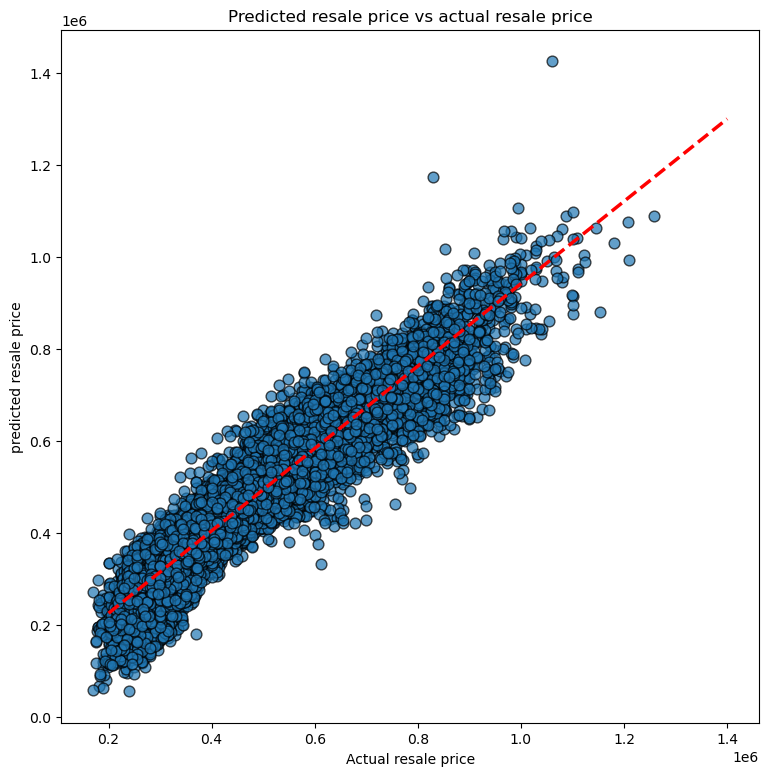

In [16]:
# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(y_test, lin_reg.predict(X_test), s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(y_test, lin_reg.predict(X_test), deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(200000, 1400000, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2.5, linestyle='dashed');

plt.xlabel('Actual resale price');
plt.ylabel('predicted resale price');
plt.title('Predicted resale price vs actual resale price')
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, lin_reg.predict(X_test))), (1, 1));
print("r-squared = {:.4f}".format(r2_score(y_test, lin_reg.predict(X_test))))#

This is a reseasonable model with very close train and test scores.   
This means that this is a decent model!  
Now, I will further investigate this model using cross validation.

In [17]:
# Build a regression model with cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = cross_val_score(lin_reg, X_train, y_train, scoring='r2', cv=folds)

In [18]:
scores

array([0.8913561 , 0.89231941, 0.89244822, 0.8928205 , 0.88969684])

In [19]:
# This function is obtained from internet source:
# https://johaupt.github.io/blog/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [20]:
%%capture --no-display
feature_name = get_feature_names(preprocessor)

In [21]:
lin_reg_features_df = pd.DataFrame(lin_reg[1].coef_.flatten(), index=feature_name)

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(lin_reg_features_df.sort_values(0, ascending=False))

                                                 0
encoder__x1_Terrace                  353387.445126
encoder__x3_Changi                   218555.671808
encoder__x3_Tanglin                  215000.213335
encoder__x3_Marine Parade            203693.243989
encoder__x3_Downtown Core            168070.375062
encoder__x3_Bukit Timah              158802.698487
encoder__x1_Improved-Maisonette      103311.259530
encoder__x3_Bishan                    93888.215852
num__floor_area_sqm                   87932.751025
encoder__x3_Bukit Merah               83841.628765
encoder__x1_Type S2                   80297.159474
encoder__x3_Outram                    78554.127834
encoder__x3_Queenstown                76375.786087
encoder__x0_MULTI-GENERATION          38082.542828
encoder__x1_Multi Generation          38082.542828
encoder__x0_EXECUTIVE                 37271.264466
encoder__x3_Kallang                   36170.708012
encoder__x3_Serangoon                 35704.619448
encoder__x0_5 ROOM             

In [23]:
lin_reg[1].intercept_

567329.5028316149

The above table show the feature name and coefficients.   
The coefficients for numerical values can't be used by itself, as the numerical values went under standard scaler.   
What this means is that, for the categorical features, as long as your flat ticks the box, then the model will add or deduct the value coefficient from the intercept value.   
The numerical features, after standard scaler, will also give you a value on how much should be added or deducted from your flat values.  

With this in mind, we can continue to try other models.  

## Lasso Regression

Lasso (least absolute shrinkage and selection operator; also Lasso or LASSO), is a regression analysis method.  
It is also termed as L1 regularization.  
It is able to shrink some coefficients to 0.  
Lasso Regression is given by:  
<img src="../img/lasso.png"></img>  
Using my own naive understanding, lasso is solving for optimal point.  
The solution to these optimal points appear when elliptical contours touch the constraints.   
Solutions exists at vertices, just like Linear Programming.  
These vertices just so happens to lie on axis.  
Which then results in at least 1 coefficent to be shrinked to 0.  
Amazing mathematics at work!

In [24]:
# Build a pipeline for regression model
# default setting did not converge
lasso = Pipeline(
    steps=[("preprocessor", preprocessor), ("Lasso", Lasso(max_iter=10000))]
)

In [25]:
lasso.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('Lasso', Lasso(max_iter=10000))])

In [26]:
print(f"The train score is: {round(lasso.score(X_train, y_train), 6)}")
print(f"The test score is: {round(lasso.score(X_test, y_test), 6)}")

The train score is: 0.891912
The test score is: 0.891241


Hmmmm, this is very close match!  
Take a look at cross validation?  

In [27]:
lasso_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Lasso CV", LassoCV(max_iter=10000, cv=5))]
)

In [28]:
lasso_CV.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('Lasso CV', LassoCV(cv=5, max_iter=10000))])

In [29]:
print(f"The train score is: {round(lasso_CV.score(X_train, y_train), 6)}")
print(f"The test score is: {round(lasso_CV.score(X_test, y_test), 6)}")

The train score is: 0.886419
The test score is: 0.886501


This is in fact lower than simply fitting using `.Lasso()`.  
Hmmm....   
This maybe becasue the model is in fact trained with smaller training data size?  
Anyways, continue to play with different alpha values.

In [30]:
# Specify range of hyperparameters to tune
lasso_params = {'alpha':[1, 10, 100, 1000]}

In [31]:
# Perform grid search using GridSearchCV()
grid_search = GridSearchCV(Lasso(max_iter=20000),
                           param_grid=lasso_params,
                           cv=5,
                           verbose = 3,
                           return_train_score=True
                           )

lasso_grid_search_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Lasso Grid Search", grid_search)]
) 

Warning, you may not want to run the line below...

In [32]:
lasso_grid_search_CV.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .......alpha=1;, score=(train=0.892, test=0.893) total time= 1.9min
[CV 2/5] END .......alpha=1;, score=(train=0.892, test=0.891) total time= 2.3min
[CV 3/5] END .......alpha=1;, score=(train=0.892, test=0.892) total time= 2.6min
[CV 4/5] END .......alpha=1;, score=(train=0.892, test=0.892) total time= 2.2min
[CV 5/5] END .......alpha=1;, score=(train=0.892, test=0.890) total time= 1.5min
[CV 1/5] END ......alpha=10;, score=(train=0.891, test=0.893) total time=  22.3s
[CV 2/5] END ......alpha=10;, score=(train=0.892, test=0.891) total time=  45.7s
[CV 3/5] END ......alpha=10;, score=(train=0.892, test=0.891) total time=   9.9s
[CV 4/5] END ......alpha=10;, score=(train=0.892, test=0.892) total time=  40.2s
[CV 5/5] END ......alpha=10;, score=(train=0.892, test=0.890) total time=  10.3s
[CV 1/5] END .....alpha=100;, score=(train=0.886, test=0.888) total time=   0.7s
[CV 2/5] END .....alpha=100;, score=(train=0.886,

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('Lasso Grid Search',
                 GridSearchCV(cv=5, estimator=Lasso(max_iter=20000),
                              param_grid={'alpha': [1, 10, 100, 1000]},
                              return_train_score=True, verbose=3))])

How naive...   
I started with    
```
'lasso_params = {'alpha':[0.01, 0.1, 1, 10, 100]}'
```
All alpha below 1 runs into convergence issues...  
For `alpha = 0.01`, the scores from grid search are around `(train=0.892, test=0.891+/-0.002)`.  
They also took a total of 2.6 minutes to run 10000 iterations and then conclude that the solution did not converge.  
This is not acceptable, as it takes too long for a simple model.  
So the final alphas to search are in the range of 1 to 100.
Alpha is the constant that multiplies the L1 term, controlling regularization strength.  
So the higher the Alpha, the more aggressive the penalization for complex model.  
The higher the penalization, the faster the convergence, as the area bounded by the constraints are larger.  
This is evident from the difference in total time used to compute the models.

In [33]:
lasso_grid_search_CV[1].best_score_

0.891718599782989

In [34]:
# cv results
cv_results = pd.DataFrame(lasso_grid_search_CV[1].cv_results_)
cv_results[['mean_fit_time', 'param_alpha', 'mean_test_score', 'mean_train_score']]

,mean_fit_time,param_alpha,mean_test_score,mean_train_score
0,126.809984,1,0.891719,0.891932
1,25.687193,10,0.891458,0.891685
2,1.036578,100,0.885856,0.886109
3,0.175098,1000,0.817216,0.817400


By looking the the results of the cross validation results, alpha = 1 gives the best result. 
The result becomes worse when alpha increases.  
There could be a possibility that a minima exists between 0 and 1.  
But I think the difference is minor and it doesn't warrant the time spent on searching for it.  
There is also a possibility (very likely in fact) that if alpha = 0 is used, it will give the best result.  
Which is simply using linear regression, like the previous section.  
If Lasso Regression must be used, I will want to use Alpha >= 100.  
This is becasue the model is solved much faster, with very small loss in performace.  

## Ridge Regression

Ridge regression is a model tuning method that is used to analyse any data that suffers from multicollinearity.   
This method performs L2 regularization.  
It is UNABLE to shrink coefficients to 0.  
Ridge Regression is given by:  
<img src="../img/ridge.png"></img>  
Using my own naive understanding, Ridge is also solving for optimal point.  
The solution to these optimal points appear when elliptical contours touch the constraints, like Lasso.   
Unlike lasso, the contraint region from Ridge are cirular.   
The coefficients will be unable to shrink to 0.  
Amazing mathematics at work again!

In [35]:
# Build a pipeline for regression model
# default setting did not converge
ridge = Pipeline(
    steps=[("preprocessor", preprocessor), ("Ridge", Ridge())]
)

In [36]:
ridge.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('Ridge', Ridge())])

In [37]:
print(f"The train score is: {round(ridge.score(X_train, y_train), 6)}")
print(f"The test score is: {round(ridge.score(X_test, y_test), 6)}")

The train score is: 0.891556
The test score is: 0.890854


It have a slightly worse performance compared to both Lasso and Linear Regression.  
Now investigate with CV.

In [38]:
ridge_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Ridge CV", RidgeCV(alphas=[0.1, 1, 10, 100, 1000], store_cv_values=True, alpha_per_target=True))]
)

In [39]:
ridge_CV.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('Ridge CV',
                 RidgeCV(alpha_per_target=True, alphas=[0.1, 1, 10, 100, 1000],
                         store_cv_values=True))])

In [40]:
print(f"The train score is: {round(ridge_CV.score(X_train, y_train), 6)}")
print(f"The test score is: {round(ridge_CV.score(X_test, y_test), 6)}")

The train score is: 0.891919
The test score is: 0.891239


In [41]:
cv_results= pd.DataFrame(ridge_CV[1].cv_values_, columns=['alpha=0.1', 'alpha=1', 'alpha=10', 'alpha=100', 'alpha=1000'])
cv_results.shape

(119817, 5)

In [42]:
cv_results.head()

,alpha=0.1,alpha=1,alpha=10,alpha=100,alpha=1000
0,2.748284e+09,2.755258e+09,2.813214e+09,3.193140e+09,4.817755e+09
1,1.418368e+09,1.423038e+09,1.457278e+09,1.611593e+09,1.377079e+09
2,1.991506e+07,1.945613e+07,1.547463e+07,8.832042e+05,1.783817e+03
3,4.380845e+09,4.388701e+09,4.462062e+09,5.059141e+09,8.126840e+09
4,1.690679e+09,1.691574e+09,1.703623e+09,1.891572e+09,3.635783e+09


In [43]:
ridge_CV[1].alpha_

0.1

In [44]:
ridge_CV[1].best_score_

-2222773760.7176504

In [45]:
ridge_CV[1].n_features_in_

75

The best Alpha selected is 0.1.  
This means the default Ridge() is good enough.  
I will now move on to Elastic Net.

## Elastic Net Regression

Elastic Net Regression is a combination of Lasso (L1) and Ridge (L2).  
Maybe that's why it is called elastic net?

In [46]:
# Build a pipeline for regression model
# default setting did not converge
e_net = Pipeline(
    steps=[("preprocessor", preprocessor), ("ENet", ElasticNet())]
)

In [47]:
e_net.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('ENet', ElasticNet())])

In [48]:
print(f"The train score is: {round(e_net.score(X_train, y_train), 6)}")
print(f"The test score is: {round(e_net.score(X_test, y_test), 6)}")

The train score is: 0.665517
The test score is: 0.665156


Wow! That is a huge drop in performance!  
Maybe do a grid sreach CV to tune the hyperparameters.

In [49]:
enet_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Ridge CV", ElasticNetCV(l1_ratio=[.1, .3 , .5, .7, .9], 
                                                                     max_iter=10000, #when l1 ratio is 0.9, it is close to a lasso, which takes a long time to run
                                                                     cv=5
                                                                    ))]
)

In [50]:
enet_CV.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('Ridge CV',
                 ElasticNetCV(cv=5, l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
                              max_iter=10000))])

In [51]:
print(f"The train score is: {round(enet_CV.score(X_train, y_train), 6)}")
print(f"The test score is: {round(enet_CV.score(X_test, y_test), 6)}")

The train score is: 0.160196
The test score is: 0.160537


Wow, this is a surprisingly low socre...  
What about grid search CV?

In [52]:
# Perform grid search using GridSearchCV()
enet_grid_search = GridSearchCV(ElasticNet(max_iter=10000),
                           param_grid={'alpha': [0.1, 1, 10],
                                       'l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9],
                                       'selection': ['cyclic', 'random'],
                                      },
                           cv=5,
                           verbose = 1,
                           return_train_score=True
                           )

enet_grid_search_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Lasso Grid Search", enet_grid_search)]
) 

In [53]:
enet_grid_search_CV.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('Lasso Grid Search',
                 GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000),
                              param_grid={'alpha': [0.1, 1, 10],
                                          'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                                          'selection': ['cyclic', 'random']},
                              return_train_score=True, verbose=1))])

In [54]:
enet_grid_search_CV[1].best_score_

0.8630536371629208

In [55]:
# cv results
cv_results = pd.DataFrame(enet_grid_search_CV[1].cv_results_)
cv_results = cv_results.loc[cv_results['param_selection'] == 'cyclic']
cv_results[['mean_fit_time', 'param_alpha', 'param_l1_ratio', 'mean_test_score', 'mean_train_score']]

,mean_fit_time,param_alpha,param_l1_ratio,mean_test_score,mean_train_score
0,0.462789,0.1,0.1,0.780479,0.780646
2,0.472705,0.1,0.3,0.792875,0.793047
4,0.539486,0.1,0.5,0.808604,0.808781
6,0.725232,0.1,0.7,0.830033,0.830218
8,1.280072,0.1,0.9,0.863054,0.863257
10,0.177696,1,0.1,0.592554,0.592667
12,0.179723,1,0.3,0.626981,0.627100
14,0.188199,1,0.5,0.665405,0.665532
16,0.212192,1,0.7,0.709749,0.709888
18,0.323020,1,0.9,0.775101,0.775266


In [56]:
# New e net with better score
e_net_new = Pipeline(
    steps=[("preprocessor", preprocessor), ("ENet", ElasticNet(alpha=0.1, l1_ratio=0.9))]
)
e_net_new.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange'])])),
                ('ENet', ElasticNet(alpha=0.1, l1_ratio=0.9))])

In [57]:
print(f"The train score is: {round(e_net_new.score(X_train, y_train), 6)}")
print(f"The test score is: {round(e_net_new.score(X_test, y_test), 6)}")

The train score is: 0.863234
The test score is: 0.863083


It is evident that when the model behaves like lasso regressor, the performance is better.  
With this, I have completed the investigation on Elastic Net Regression.

## Model Evaluation

Here, I will take a (slightly) closer look at the four models used.  
I will look at the scores, where the default is the r-squared value, first.  
I will peek at the coefficients.  
Then I will make inference using the models, and take a look at the MSE, RMSE, AME.

Lasso is using 'diamond' shaped constriants.  
Ridge is using 'circle' shaped constraints.  
Once the elliptical contours hits the constraints, optimality is reached.  
But becasue 'diamond' have vertices on axis, it will shrink at least 1 coefficient to 0.

<img src="../img/lasso_vs_ridge.png" width="500" height="600"></img>  

Ridge, on the other hand will not, as optimal point will not lie on axis, which are representing features.  
(Unless the whole B_hat lies on axis, resulting in a trivial solution? This is just my guess)

Based oon the scores alone, which is in fact R squared value.   
Lasso regression edges out a little bit, followed closely by Lasso, then Ridge.   
Elastic Net have the worst performance.  

Now, I will test this with kaggle.  

In [58]:
# Import test set
test = pd.read_csv('../datasets/test.csv')

/tmp/ipykernel_1084/575172797.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('../datasets/test.csv')


In [59]:
pred_res = lin_reg.predict(test)

In [60]:
id_col = test['id'].copy(deep=True)
res = zip(id_col,pred_res)
result = pd.DataFrame(res, columns=['id', 'Predicted'])
result.to_csv('../datasets/prediction_linear.csv', index=False)

The Root Mean Square Error (RMSE) score from the most basic linear regression model is:  
<img src="../img/lin_reg_res.png"></img> 
Looking at the score alone, it's kind of expected. It is not great, but not too bad.

In [61]:
pred_res = lasso.predict(test)

In [62]:
id_col = test['id'].copy(deep=True)
res = zip(id_col,pred_res)
result_lasso = pd.DataFrame(res, columns=['id', 'Predicted'])
result_lasso.to_csv('../datasets/prediction_lasso.csv', index=False)

The Root Mean Square Error (RMSE) score from the lasso regression model is:  
<img src="../img/lasso_res.png"></img> 
This is actually (slightly) worse off compared to linear regression.  
The difference is rather small, but one thing to keep in mind is the 'bias variance tradeoff'.  
In lasso, my bias might be lower and my variance might be higher, the model might have over learned a tiny bit more compared to linear regression.  
It doesn't generalise as well.

This also shows that high R sqaured doesn't mean it's good, as the original distribution of the data may not follow a linear distribution completely in the first place!  

With this in mind, the last 'One Size Fit All' model to test will be the Elastic Net model.  
This is because Elastic Net have a very different score compared to all other models. 

In [63]:
pred_res = e_net.predict(test)

In [64]:
id_col = test['id'].copy(deep=True)
res = zip(id_col,pred_res)
result_enet = pd.DataFrame(res, columns=['id', 'Predicted'])
result_enet.to_csv('../datasets/prediction_enet.csv', index=False)

<img src="../img/enet_res.png"></img> 
The 2nd submission in the screenshot is using the original elastic net model, where all parameters are default value.  
The 1st submission in the screenshot is using the optimised elastic net model from grid search CV.  
It can be seen that is a huge improvement on RMSE.  
However, they still pales in comparison to simple linear regression.  

In [65]:
# rough ESTIMATE of baseline benchmark RMSE
actual = list(df['resale_price'])
mean_price = df['resale_price'].mean()
mean_price_list = [mean_price]*149772
metrics.mean_squared_error(actual, mean_price_list, squared=False)

143225.55449855106

All models performed better than 'baseline' model.  
To conclude off, for this case, it seems that a simple linear regression should be the go to model.  
This is becasue it is simple and fast, with good performance in terms of r sqaured score and RSME score.  
This concludes the exploration on a single model.  

## Combined Model

This section explors the possibility of using a combination of models to find the housing price.  
The reason behind this is that, a single model can not capture the unique characteristics of what contributes to the housing price.  
Hence, we use more than one model to 'learn' it!  
This is makes the model more complex.  
The base models will be simple linear regression, as linear regression is proven to work well in the previous section.  
It ought to work well here too, as they share the same use case.  
The drawback can be that the ammount of data for each model to learn is smaller.  

In [66]:
# Import training data again
df = pd.read_csv('../datasets/reduced_train.csv')
df.head()

,id,flat_type,floor_area_sqm,flat_model,resale_price,Tranc_Year,mid,hdb_age,max_floor_lvl,planning_area,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_interchange,mrt_interchange,cutoff_point
0,88471,4 ROOM,90.0,Model A,680000.0,2016,11,15,25,Kallang,1094.090418,154.753357,330.083069,0,0,224
1,122598,5 ROOM,130.0,Improved,665000.0,2012,8,34,9,Bishan,866.941448,640.151925,903.659703,1,1,232
2,170897,EXECUTIVE,144.0,Apartment,838000.0,2013,14,24,16,Bukit Batok,1459.579948,1762.082341,1334.251197,1,0,188
3,86070,4 ROOM,103.0,Model A,550000.0,2012,3,29,11,Bishan,950.175199,726.215262,907.453484,1,1,253
4,153632,4 ROOM,83.0,Simplified,298000.0,2017,2,34,4,Yishun,729.771895,1540.151439,412.343032,0,0,208


The data provided can be split into higher end and lower end flats by using `flat_type` alone.  
As shown in the [EDA analysis](./house_EDA.ipynb) for resale price vs flat type, the flat types with 3 room or less is significantly lower than other flat types.  
Unfortunately, nothing I do worked...
The trained models are not able to generalise.  
The error is that the number of features needed is different from what I can pass.   
This is probably because of the one hot encoder used...   
This problem can't be solved as I am using pipeline.   
If I really want to do multiple models, I guess I have to it very manually. 

Without more time to explore, I decided to give a last desperate attempt at model creation.  
The codes were very poorly written.  

In [67]:
test = pd.read_csv('../datasets/test.csv')

/tmp/ipykernel_1084/1638058713.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('../datasets/test.csv')


In [68]:
df.index

RangeIndex(start=0, stop=149772, step=1)

In [69]:
# find the list of colmuns to drop
df.columns
test.columns
drop_col = [col for col in test.columns if col not in df.columns]

In [70]:
# drop colmuns that should be droped
test.drop(columns=drop_col, inplace=True)

In [71]:
# comnbine train and test, only doing this for one hot encoding of data
df = pd.concat([df, test])

In [72]:
# drop numerical features
df_cat = df.drop(columns=numerical_col)

In [73]:
# drop categorical colmuns
df_num = df.drop(columns=categorical_col)

In [74]:
df_cat.head()

,id,flat_type,flat_model,resale_price,Tranc_Year,planning_area,bus_interchange,mrt_interchange
0,88471,4 ROOM,Model A,680000.0,2016,Kallang,0,0
1,122598,5 ROOM,Improved,665000.0,2012,Bishan,1,1
2,170897,EXECUTIVE,Apartment,838000.0,2013,Bukit Batok,1,0
3,86070,4 ROOM,Model A,550000.0,2012,Bishan,1,1
4,153632,4 ROOM,Simplified,298000.0,2017,Yishun,0,0


In [75]:
# find flate models
flat_type_present = list(df_cat['flat_type'].unique())
flat_type_present

['4 ROOM',
 '5 ROOM',
 'EXECUTIVE',
 '3 ROOM',
 '2 ROOM',
 '1 ROOM',
 'MULTI-GENERATION']

In [76]:
# find planning area
planning_area_present = list(df_cat['planning_area'].unique())
planning_area_present

['Kallang',
 'Bishan',
 'Bukit Batok',
 'Yishun',
 'Geylang',
 'Hougang',
 'Bedok',
 'Sengkang',
 'Tampines',
 'Serangoon',
 'Bukit Merah',
 'Bukit Panjang',
 'Woodlands',
 'Jurong West',
 'Toa Payoh',
 'Choa Chu Kang',
 'Sembawang',
 'Novena',
 'Ang Mo Kio',
 'Pasir Ris',
 'Clementi',
 'Punggol',
 'Jurong East',
 'Rochor',
 'Queenstown',
 'Bukit Timah',
 'Outram',
 'Tanglin',
 'Marine Parade',
 'Western Water Catchment',
 'Downtown Core',
 'Changi']

In [77]:
# Define the types to split by
less_rm = ['3 ROOM', '2 ROOM', '1 ROOM']
more_rm = ['4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
high_area = ['Bishan', 'Bukit Merah', 'Queenstown', 'Bukit Timah', 'Outram', 'Tanglin', 'Marine Parade', 'Downtown Core']
other_area = [loc for loc in planning_area_present if loc not in high_area]

In [78]:
other_area # other areas that doesn't have exceptionally high price

['Kallang',
 'Bukit Batok',
 'Yishun',
 'Geylang',
 'Hougang',
 'Bedok',
 'Sengkang',
 'Tampines',
 'Serangoon',
 'Bukit Panjang',
 'Woodlands',
 'Jurong West',
 'Toa Payoh',
 'Choa Chu Kang',
 'Sembawang',
 'Novena',
 'Ang Mo Kio',
 'Pasir Ris',
 'Clementi',
 'Punggol',
 'Jurong East',
 'Rochor',
 'Western Water Catchment',
 'Changi']

In [79]:
df_num.head()

,id,floor_area_sqm,resale_price,mid,hdb_age,max_floor_lvl,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,cutoff_point
0,88471,90.0,680000.0,11,15,25,1094.090418,154.753357,330.083069,224
1,122598,130.0,665000.0,8,34,9,866.941448,640.151925,903.659703,232
2,170897,144.0,838000.0,14,24,16,1459.579948,1762.082341,1334.251197,188
3,86070,103.0,550000.0,3,29,11,950.175199,726.215262,907.453484,253
4,153632,83.0,298000.0,2,34,4,729.771895,1540.151439,412.343032,208


In [80]:
# do not include drop first for sake of analysis of features!
df_cat = pd.get_dummies(df_cat)

In [81]:
df_cat.head()

,id,resale_price,Tranc_Year,bus_interchange,mrt_interchange,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,...,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,88471,680000.0,2016,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,122598,665000.0,2012,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,170897,838000.0,2013,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,86070,550000.0,2012,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,153632,298000.0,2017,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [82]:
ohe_col = list(df_cat.columns)
ohe_col.remove('id')
ohe_col.remove('resale_price')
len(ohe_col)

62

In [83]:
df = df_num.merge(df_cat)

In [84]:
df.shape

(166509, 72)

In [85]:
df = df.iloc[0:149772]

In [86]:
df.drop(columns=['id'], inplace=True)

In [87]:
df.head()

,floor_area_sqm,resale_price,mid,hdb_age,max_floor_lvl,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,cutoff_point,Tranc_Year,...,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,90.0,680000.0,11,15,25,1094.090418,154.753357,330.083069,224,2016,...,0,0,0,0,0,0,0,0,0,0
1,130.0,665000.0,8,34,9,866.941448,640.151925,903.659703,232,2012,...,0,0,0,0,0,0,0,0,0,0
2,144.0,838000.0,14,24,16,1459.579948,1762.082341,1334.251197,188,2013,...,0,0,0,0,0,0,0,0,0,0
3,103.0,550000.0,3,29,11,950.175199,726.215262,907.453484,253,2012,...,0,0,0,0,0,0,0,0,0,0
4,83.0,298000.0,2,34,4,729.771895,1540.151439,412.343032,208,2017,...,0,0,0,0,0,0,0,0,0,1


## Split Data by features

2 type of features are selected to build 4 models.  
The first type of feature is the flat type, which roughly translate into the number of rooms.   
Another is the location of flat, given by planning area.  

In [88]:
# One Hot Encoded name
less_rm = ['flat_type_'+rm for rm in less_rm]
more_rm = ['flat_type_'+rm for rm in more_rm]
high_area = ['planning_area_'+area for area in high_area]
other_area = ['planning_area_'+area for area in other_area]

In [89]:
# build model based on different datasets
# split the df into different datasets
def filter_df(df, targets):
    '''filter the dataframe input
    args: 
        df: original dataframe to filter
        targets: list of targets to filter
    out:
        df_comb: combined df of filter result
    '''
    df_comb = df.loc[df[targets[0]]==1]
    for tar in targets[1:]:
        df_temp = df.loc[df[tar]==1]
        df_comb = pd.concat([df_comb, df_temp])
    return df_comb

In [90]:
df_less_rm = filter_df(df, less_rm).copy(deep=True)

In [91]:
df_more_rm = filter_df(df, more_rm).copy(deep=True)

In [92]:
print(f"Smaller flats makes a total of {round((df_less_rm.shape[0]/df.shape[0])*100,2)} % of the original training data.")

Smaller flats makes a total of 27.29 % of the original training data.


In [93]:
df_high_area = filter_df(df, high_area).copy(deep=True)

In [94]:
df_other_area = filter_df(df, other_area).copy(deep=True)

In [95]:
print(f"High valued area makes a total of {round((df_high_area.shape[0]/df.shape[0])*100,2)} % of the original training data.")

High valued area makes a total of 9.93 % of the original training data.


In [96]:
# Split the data into X and y
def split_X_y(df, y_name):
    '''This function splits the dataframe and return the X and y
    args:
        df: original
        y_name: target feature name
    out:
        X: training features
        y: target features
    '''
    y = df[y_name]
    X = df.drop(columns=[y_name])
    return X, y

In [97]:
# Split the dataset for X and y
X_less_rm, y_less_rm = split_X_y(df_less_rm, 'resale_price')
X_more_rm, y_more_rm = split_X_y(df_more_rm, 'resale_price')
X_high_area, y_high_area = split_X_y(df_high_area, 'resale_price')
X_other_area, y_other_area = split_X_y(df_other_area, 'resale_price')

In [98]:
# Split the data using train test split.
X_less_rm_train, X_less_rm_test, y_less_rm_train, y_less_rm_test = train_test_split(X_less_rm, y_less_rm, test_size=0.2, random_state=0)
X_more_rm_train, X_more_rm_test, y_more_rm_train, y_more_rm_test = train_test_split(X_more_rm, y_more_rm, test_size=0.2, random_state=0)
X_high_area_train, X_high_area_test, y_high_area_train, y_high_area_test = train_test_split(X_high_area, y_high_area, test_size=0.2, random_state=0)
X_other_area_train, X_other_area_test, y_other_area_train, y_other_area_test = train_test_split(X_other_area, y_other_area, test_size=0.2, random_state=0)

In [99]:
numeric_transformer = Pipeline(
    steps=[("simple impute", SimpleImputer(missing_values=np.nan, strategy='mean')),
           ("scaler", StandardScaler())
            ]
)

In [100]:
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numerical_col),('ohe columns', 'passthrough', ohe_col)]
)

As explained earlier on, I will choose `LinearRegression()`, since it is simpler.  
I have tested Ridge and Lasso as well as Elastic Net here, without tunning.  
Performance wise, `LinearRegression()` is on par or exceeds the rest.

## Make 4 Models

As there are 2 types, and each type is split into 2 sets of data, I need 4 models in total.  

In [101]:
# Build a pipeline for regression model
less_rm_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
less_rm_reg.fit(X_less_rm_train, y_less_rm_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('ohe columns', 'passthrough',
                                                  ['Tranc_Year',
                                                   'bus_interchange...
                                                   'flat_model_Model '
                                                   'A-Maisonette',
                                                   'flat_model_Model A2',
                                                   'flat_model_Multi '
                                                   'Generation',
                                                   'flat_model_New Generation',
                                                   'flat_model_Premium '
                                                   'Apartment',
                                                   'flat_model_Premium '
                                                   'Apartment Loft',
                                                   'flat_model_Premium '
                                                   'Maisonette',
                                                   'flat_model_Simplified',
                                                   'flat_model_Standard',
                                                   'flat_model_Terrace',
                                                   'flat_model_Type S1',
                                                   'flat_model_Type S2', ...])])),
                ('regressor', LinearRegression())])

In [102]:
print(f"The train score is: {round(less_rm_reg.score(X_less_rm_train, y_less_rm_train), 6)}")
print(f"The test score is: {round(less_rm_reg.score(X_less_rm_test, y_less_rm_test), 6)}")

The train score is: 0.795677
The test score is: 0.800111


In [103]:
# Build a pipeline for regression model
more_rm_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
more_rm_reg.fit(X_more_rm_train, y_more_rm_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('ohe columns', 'passthrough',
                                                  ['Tranc_Year',
                                                   'bus_interchange...
                                                   'flat_model_Model '
                                                   'A-Maisonette',
                                                   'flat_model_Model A2',
                                                   'flat_model_Multi '
                                                   'Generation',
                                                   'flat_model_New Generation',
                                                   'flat_model_Premium '
                                                   'Apartment',
                                                   'flat_model_Premium '
                                                   'Apartment Loft',
                                                   'flat_model_Premium '
                                                   'Maisonette',
                                                   'flat_model_Simplified',
                                                   'flat_model_Standard',
                                                   'flat_model_Terrace',
                                                   'flat_model_Type S1',
                                                   'flat_model_Type S2', ...])])),
                ('regressor', LinearRegression())])

In [104]:
print(f"The train score is: {round(more_rm_reg.score(X_more_rm_train, y_more_rm_train), 6)}")
print(f"The test score is: {round(more_rm_reg.score(X_more_rm_test, y_more_rm_test), 6)}")

The train score is: 0.874978
The test score is: 0.874102


In [105]:
high_area_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
high_area_reg.fit(X_high_area_train, y_high_area_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('ohe columns', 'passthrough',
                                                  ['Tranc_Year',
                                                   'bus_interchange...
                                                   'flat_model_Model '
                                                   'A-Maisonette',
                                                   'flat_model_Model A2',
                                                   'flat_model_Multi '
                                                   'Generation',
                                                   'flat_model_New Generation',
                                                   'flat_model_Premium '
                                                   'Apartment',
                                                   'flat_model_Premium '
                                                   'Apartment Loft',
                                                   'flat_model_Premium '
                                                   'Maisonette',
                                                   'flat_model_Simplified',
                                                   'flat_model_Standard',
                                                   'flat_model_Terrace',
                                                   'flat_model_Type S1',
                                                   'flat_model_Type S2', ...])])),
                ('regressor', LinearRegression())])

In [106]:
print(f"The train score is: {round(high_area_reg.score(X_high_area_train, y_high_area_train), 6)}")
print(f"The test score is: {round(high_area_reg.score(X_high_area_test, y_high_area_test), 6)}")

The train score is: 0.933377
The test score is: 0.933121


In [107]:
other_area_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", Ridge())]
)
other_area_reg.fit(X_other_area_train, y_other_area_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple '
                                                                   'impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm', 'mid',
                                                   'hdb_age', 'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Hawker_Nearest_Distance',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point']),
                                                 ('ohe columns', 'passthrough',
                                                  ['Tranc_Year',
                                                   'bus_interchange...
                                                   'flat_model_Model '
                                                   'A-Maisonette',
                                                   'flat_model_Model A2',
                                                   'flat_model_Multi '
                                                   'Generation',
                                                   'flat_model_New Generation',
                                                   'flat_model_Premium '
                                                   'Apartment',
                                                   'flat_model_Premium '
                                                   'Apartment Loft',
                                                   'flat_model_Premium '
                                                   'Maisonette',
                                                   'flat_model_Simplified',
                                                   'flat_model_Standard',
                                                   'flat_model_Terrace',
                                                   'flat_model_Type S1',
                                                   'flat_model_Type S2', ...])])),
                ('regressor', Ridge())])

In [108]:
print(f"The train score is: {round(other_area_reg.score(X_other_area_train, y_other_area_train), 6)}")
print(f"The test score is: {round(other_area_reg.score(X_other_area_test, y_other_area_test), 6)}")

The train score is: 0.869091
The test score is: 0.867971


## Combine the model

Combine the four models made earlier into a single model.   
This single model should give a prediction with the proper input features.

In [109]:
def find_tag(df, target):
    '''Find the tag for that 1 single row of dataframe
    '''
    for tar in target:
        if len(df.loc[df[tar]==1]):
            return True
    

In [110]:
def predict_one(i, df, less_rm, high_area, w_type, w_area):
    '''predict price for 1 flat
    args:
        i: index of dataframe
        df: dataframe to predict on
        more_rm: more
    '''
    # Check flat classification
    less_rm_flat = find_tag(df.iloc[[i]], less_rm)
    high_area_flat = find_tag(df.iloc[[i]], high_area)
    
    # Predict flat price
    if less_rm_flat:
        res_f_type = less_rm_reg.predict(df.iloc[[i]])
    else:
        res_f_type = more_rm_reg.predict(df.iloc[[i]])

    if high_area_flat:
        res_p_area = high_area_reg.predict(df.iloc[[i]])
    else:
        res_p_area = other_area_reg.predict(df.iloc[[i]])

    w_res = float(w_type*res_f_type + w_area*res_p_area)    
    return w_res

In [111]:
def predict_price(df, less_rm, high_area, w_type=0.4, w_area=0.6):
    res_list = []
    for i in range(df.shape[0]):
        res_one = predict_one(i, df, less_rm, high_area, w_type, w_area)
        res_list.append(res_one)
    return res_list

The long chunk below should be a function/ class.  
Which I can write but don't have time for :<

## Prediction and Analysis

Here, the price is predicted using the combined model.   
Then, analyse the results.  

In [112]:
# Repeat preparing of data...
df = pd.read_csv('../datasets/reduced_train.csv')
test = pd.read_csv('../datasets/test.csv')
df.index
# find the list of colmuns to drop
df.columns
test.columns
drop_col = [col for col in test.columns if col not in df.columns]
# drop colmuns that should be droped
test.drop(columns=drop_col, inplace=True)
# comnbine train and test, only doing this for one hot encoding of data
df = pd.concat([df, test])
# drop numerical features
df_cat = df.drop(columns=numerical_col)
# drop categorical colmuns
df_num = df.drop(columns=categorical_col)


flat_type_present = list(df_cat['flat_type'].unique())
planning_area_present = list(df_cat['planning_area'].unique())

# do not include drop first for sake of analysis of features!
df_cat = pd.get_dummies(df_cat)

ohe_col = list(df_cat.columns)
ohe_col.remove('id')
ohe_col.remove('resale_price')

df = df_num.merge(df_cat)

/tmp/ipykernel_1084/3848060463.py:3: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('../datasets/test.csv')


In [113]:
df = df.iloc[149772:]

In [114]:
df_id_dict = {'id': list(df['id'])}

In [115]:
df.drop(columns=['id', 'resale_price'], inplace=True)

In [116]:
df.reset_index(drop=True, inplace=True)

In [117]:
df.head()

,floor_area_sqm,mid,hdb_age,max_floor_lvl,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,cutoff_point,Tranc_Year,bus_interchange,...,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,84.0,8,34,12,877.431572,687.576779,686.660434,218,2012,0,...,0,0,0,0,0,0,0,0,0,1
1,112.0,5,13,14,534.037705,2122.346226,169.478175,199,2019,0,...,0,0,0,0,0,0,0,0,0,0
2,68.0,8,41,12,817.050453,152.287621,694.220448,245,2013,1,...,0,0,0,0,0,0,0,0,0,0
3,97.0,2,42,14,1272.737194,501.892158,1117.203587,188,2017,0,...,0,0,0,0,0,0,0,0,1,0
4,103.0,17,36,25,1070.963675,437.593564,987.976010,223,2016,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
res_list = predict_price(df, less_rm, high_area)

In [119]:
df_id_dict['Predicted'] = res_list
result_combi = pd.DataFrame(df_id_dict)
result_combi.to_csv('../datasets/prediction_combi.csv', index=False)

<img src="../img/mixed_res.png"></img> 
This is the RSME score for mixed model.  
However, the scores may increase further if I have enouch time to tune the hyper parameters.   
Which is the weight on these models.  
This model performed worse than simple linear regression.  
This is likely because how crude the model is.   

# Conclusion

Out of all the models, the simple linear regression model have the best performance.  
The combination of models do have a lot of potential, and can probably be improved by tuning the hyper parameters, such as the weightage on different models.  
Also, the classification of models can be made better.   
For exmample, I can exclude the three room flats and shift it to the more room category.  
Otherwise, I can also try to further refine the model by flat type and location.  

The simple linear regression model is able to explain both the train and test data well.   
However, the unfortunate thing is that some factors can't be taken into account.  
Such as the direction the flat is facing, government policies and interventions.  

In conclusion, a simple linear model is able to explain most of the resale flats, by selecting the proper features.  
The R sqaured is 0.8912.  
This means that 89.12% of the variation in resale price to test set, which is not seen by model, can be explianed by the model.  
The RMSE is around $47,000.  
This means that the actual price is very likely around predicted price +/- RMSE, on average.  